Optimizing Rosenbrock Function (2D)

--- Running SGD without momentum (NumPy) ---
Optimizer: SGD without momentum (NumPy), Iterations: 15000, Learning Rate: 0.000005
  Iter     1/15001, Loss: 242.82006317, Params: [-0.5018  1.8029]
  Iter  1500/15000, Loss: 4.69555980, Params: [-1.1654  1.3663]
  Iter  3000/15000, Loss: 4.67365105, Params: [-1.1604  1.3545]
  Iter  4500/15000, Loss: 4.65169631, Params: [-1.1553  1.3427]
  Iter  6000/15000, Loss: 4.62968213, Params: [-1.1502  1.3309]
  Iter  7500/15000, Loss: 4.60760777, Params: [-1.1451  1.3191]
  Iter  9000/15000, Loss: 4.58547250, Params: [-1.1399  1.3073]
  Iter 10500/15000, Loss: 4.56327559, Params: [-1.1347  1.2955]
  Iter 12000/15000, Loss: 4.54101627, Params: [-1.1295  1.2837]
  Iter 13500/15000, Loss: 4.51869376, Params: [-1.1243  1.2718]
  Iter 15000/15000, Loss: 4.49630728, Params: [-1.119  1.26 ]
--- SGD without momentum (NumPy) Finished ---
Total Iterations Run: 15000
Time: 0.1285s
Final Loss: 4.49630728
Final Params: [-1.1

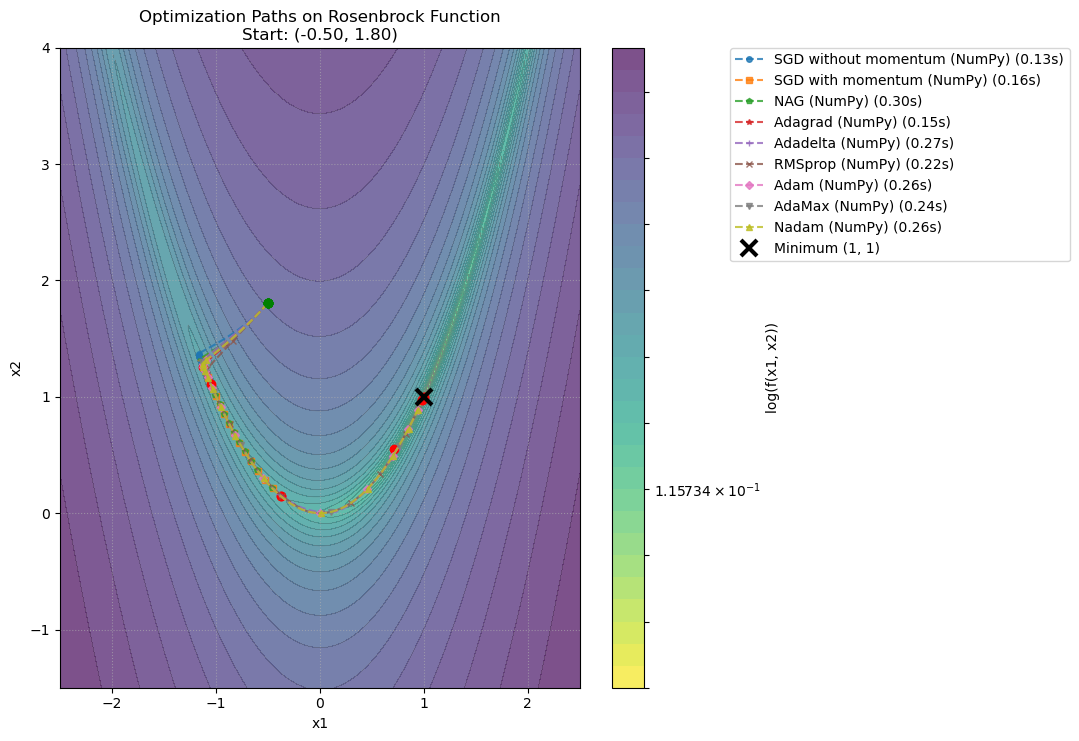

Saving plot to optimization_plots/rosenbrock_2d_convergence.png...


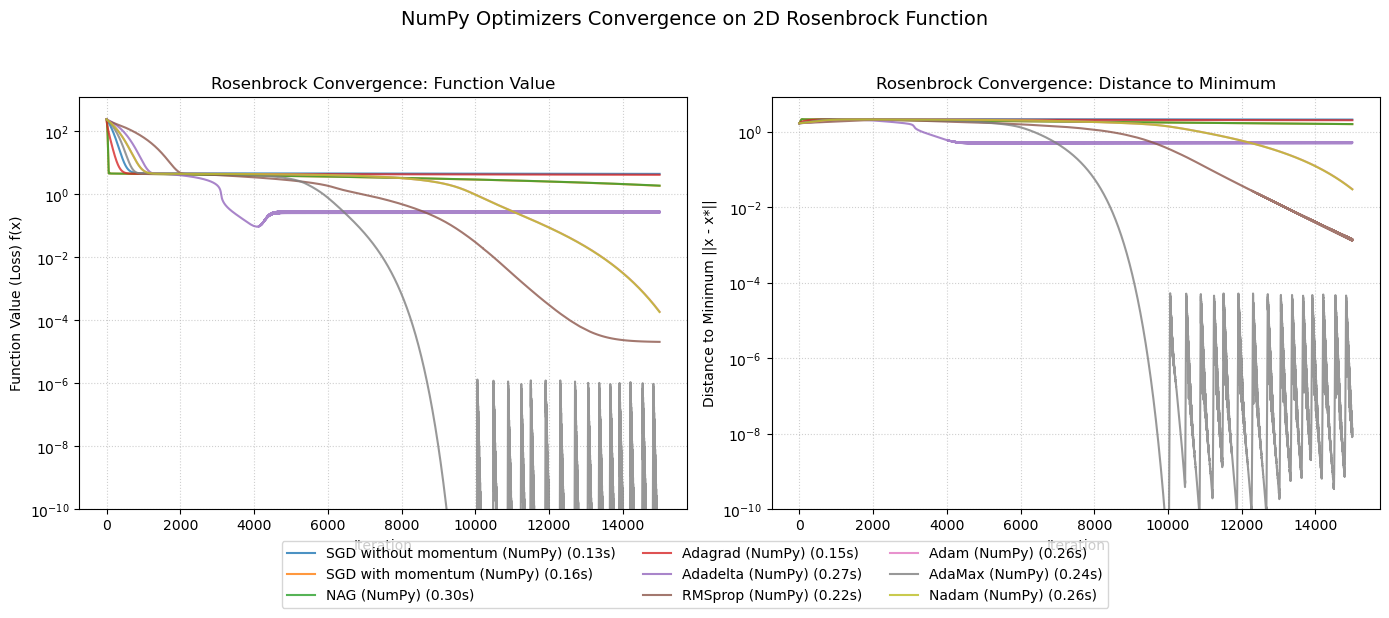


--- Quadratic Plots ---
Saving plot to optimization_plots/quadratic_3d_paths.png...


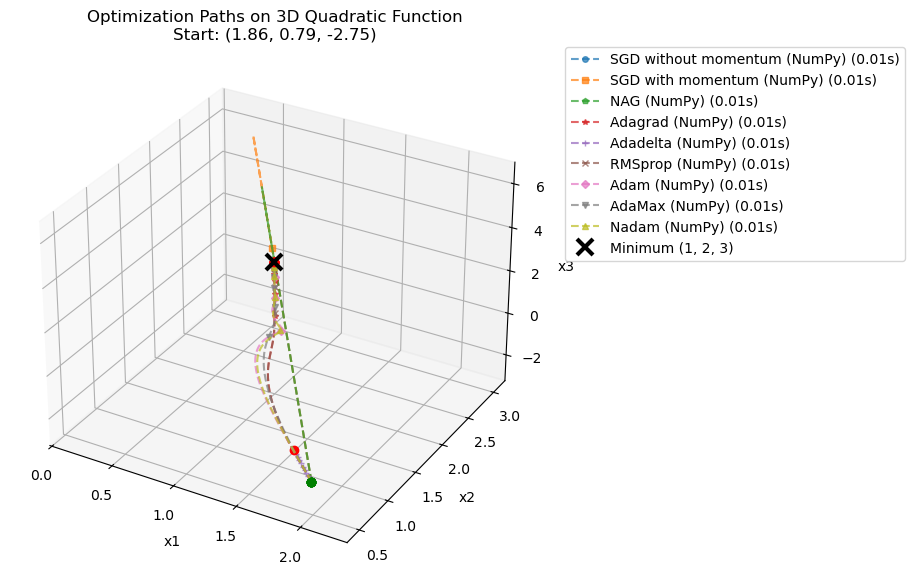

Saving plot to optimization_plots/quadratic_3d_convergence.png...


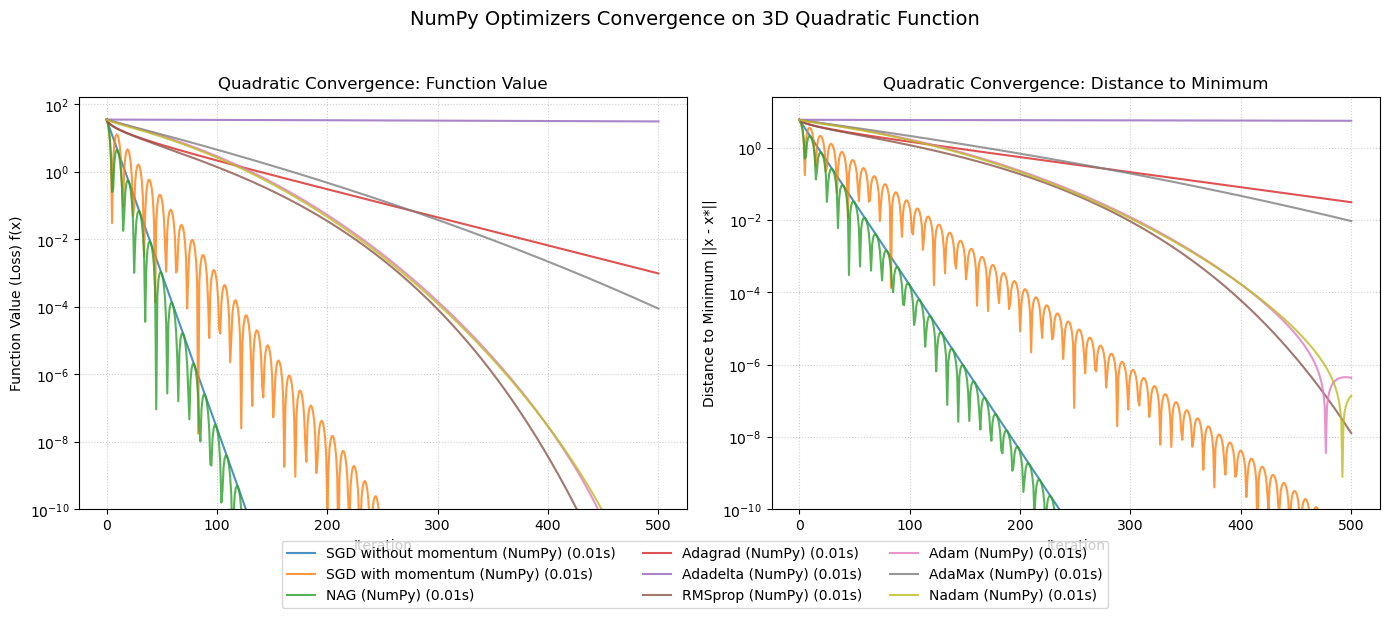


Script finished. Plots saved in directory: optimization_plots


In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting
from collections import defaultdict
import time
import warnings
import os

# --- Function Definitions (NumPy) ---

def rosenbrock_np(x):
    """Rosenbrock function (2D). Expects a 1D array/list [x1, x2]."""
    x = np.asarray(x, dtype=np.float64)
    if x.ndim != 1 or x.shape[0] != 2:
        raise ValueError(f"Rosenbrock function defined here expects a 1D array of shape (2,), got shape {x.shape} and ndim {x.ndim}")
    x0 = x[0]
    x1 = x[1]
    # Handle NaN/Inf input gracefully
    if not np.all(np.isfinite(x)):
        return np.inf
    val = (1 - x0)**2 + 100 * (x1 - x0**2)**2
    return val if np.isfinite(val) else np.inf


def grad_rosenbrock_np(x):
    """Gradient of the Rosenbrock function (2D)."""
    x = np.asarray(x, dtype=np.float64)
    if x.shape[0] != 2:
        raise ValueError("Gradient for Rosenbrock function defined here is 2D")
    # Handle NaN/Inf input gracefully
    if not np.all(np.isfinite(x)):
        return np.array([np.nan, np.nan], dtype=np.float64)
    dx1 = -2.0 * (1 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    dx2 = 200.0 * (x[1] - x[0]**2)
    grad = np.array([dx1, dx2])
    grad[~np.isfinite(grad)] = np.nan # Handle NaN/Inf results
    return grad

def quadratic_np(x):
    """Simple quadratic function (3D)."""
    x = np.asarray(x, dtype=np.float64)
    if x.shape[0] != 3:
        raise ValueError("Quadratic function defined here is 3D")
    target = np.array([1, 2, 3], dtype=np.float64)
    if not np.all(np.isfinite(x)):
        return np.inf
    val = np.sum((x - target)**2)
    return val if np.isfinite(val) else np.inf

def grad_quadratic_np(x):
    """Gradient of the simple quadratic function (3D)."""
    x = np.asarray(x, dtype=np.float64)
    if x.shape[0] != 3:
        raise ValueError("Gradient for Quadratic function defined here is 3D")
    target = np.array([1, 2, 3], dtype=np.float64)
    if not np.all(np.isfinite(x)):
        return np.array([np.nan, np.nan, np.nan], dtype=np.float64)
    grad = 2.0 * (x - target)
    grad[~np.isfinite(grad)] = np.nan
    return grad

# --- Data Generation ---

def generate_initial_point(dim, low=-4, high=4):
    """Generates a random initial point."""
    return np.random.uniform(low, high, size=dim).astype(np.float64)

# --- Optimizer Implementation (NumPy) ---

def run_numpy_optimizers(func, grad_func, initial_point, dim, optimizers_to_run,
                         base_lr=0.001, iterations=1000, gradient_noise_std=0.0,
                         specific_lrs=None, print_freq=100):
    """
    Runs manually implemented optimizers using NumPy. Includes NaN/Inf handling.
    """
    results = defaultdict(lambda: {'path': [], 'time': 0.0, 'losses': []})
    epsilon = 1e-8 # Small value for numerical stability in adaptive methods

    if specific_lrs is None:
        specific_lrs = {}

    for name in optimizers_to_run:
        print(f"\n--- Running {name} ---")
        lr = specific_lrs.get(name, base_lr)
        if name == "Adadelta (NumPy)":
             print(f"Optimizer: {name}, Iterations: {iterations} (lr usually ignored or scales update)")
        else:
             print(f"Optimizer: {name}, Iterations: {iterations}, Learning Rate: {lr:.6f}")

        # Initialize parameters and results lists
        params = initial_point.copy()
        path = [params.copy()]

        initial_loss = func(params)
        losses = [initial_loss]
        if not np.isfinite(initial_loss):
             print(f"Warning: Initial loss is {initial_loss} for {name}. Skipping.")
             results[name]['path'] = np.array(path)
             results[name]['losses'] = np.array(losses)
             results[name]['time'] = 0.0
             continue

        start_time = time.time()

        # Optimizer-specific state variables
        velocity = np.zeros_like(params, dtype=np.float64) # Momentum, NAG
        beta_momentum = 0.9
        grad_squared_sum = np.zeros_like(params, dtype=np.float64) # Adagrad
        Eg = np.zeros_like(params, dtype=np.float64)     # Exp. avg squared grads (Adadelta, RMSprop)
        Edx = np.zeros_like(params, dtype=np.float64)    # Exp. avg squared updates (Adadelta)
        rho_adadelta = 0.95
        beta2_rmsprop = 0.99
        m = np.zeros_like(params, dtype=np.float64)      # 1st moment vector (Adam family)
        v = np.zeros_like(params, dtype=np.float64)      # 2nd moment vector (Adam, Nadam)
        u = np.zeros_like(params, dtype=np.float64)      # Exp weighted infinity norm (AdaMax)
        beta1 = 0.9
        beta2 = 0.999
        t = 0 # Timestep counter for bias correction

        # Print initial state
        if (0 + 1) % print_freq == 0 or 0 == 0:
            loss_str = f"{initial_loss:.8f}"
            params_str = np.round(params, 4)
            print(f"  Iter {1:>5}/{iterations+1}, Loss: {loss_str}, Params: {params_str}") # Show iter 1 for initial state

        # Optimization Loop
        for i in range(iterations):
            t += 1
            params_prev = params.copy() # Store previous state for potential rollback

            # Calculate gradient and check validity
            grad = grad_func(params)
            if not np.all(np.isfinite(grad)):
                print(f"Warning: NaN/Inf gradient encountered at iter {i+1}. Stopping {name}.")
                break

            # Add optional gradient noise
            if gradient_noise_std > 0:
                grad += np.random.normal(0, gradient_noise_std, size=params.shape)
                if not np.all(np.isfinite(grad)):
                    print(f"Warning: NaN/Inf gradient after adding noise at iter {i+1}. Stopping {name}.")
                    break

            # Apply Optimizer Update Rule within a try-except block
            try:
                if name in ["BGD (NumPy)", "SGD without momentum (NumPy)", "Mini-batch GD (NumPy)"]:
                    update = lr * grad
                    params = params - update
                elif name == "SGD with momentum (NumPy)":
                    velocity = beta_momentum * velocity + lr * grad
                    update = velocity
                    params = params - update
                elif name == "NAG (NumPy)":
                    params_lookahead = params - beta_momentum * velocity
                    grad_lookahead = grad_func(params_lookahead)
                    if not np.all(np.isfinite(grad_lookahead)): raise ValueError("NaN/Inf in NAG lookahead gradient")
                    if gradient_noise_std > 0: grad_lookahead += np.random.normal(0, gradient_noise_std, size=params.shape)
                    if not np.all(np.isfinite(grad_lookahead)): raise ValueError("NaN/Inf in NAG lookahead gradient after noise")
                    velocity = beta_momentum * velocity + lr * grad_lookahead
                    update = velocity
                    params = params - update
                elif name == "Adagrad (NumPy)":
                    grad_squared_sum += grad * grad
                    adjusted_lr = lr / (np.sqrt(grad_squared_sum) + epsilon)
                    update = adjusted_lr * grad
                    params = params - update
                elif name == "Adadelta (NumPy)":
                     Eg = rho_adadelta * Eg + (1 - rho_adadelta) * grad * grad
                     delta_x_num = np.sqrt(Edx + epsilon)
                     delta_x_den = np.sqrt(Eg + epsilon)
                     safe_den = np.where(delta_x_den == 0, epsilon, delta_x_den) # Avoid division by zero
                     delta_x = - (delta_x_num / safe_den) * grad
                     Edx = rho_adadelta * Edx + (1 - rho_adadelta) * delta_x * delta_x
                     update = delta_x
                     params = params + delta_x # Adadelta *adds* the update
                elif name == "RMSprop (NumPy)":
                     Eg = beta2_rmsprop * Eg + (1 - beta2_rmsprop) * grad * grad
                     sqrt_Eg = np.sqrt(np.maximum(Eg, 0)) + epsilon # Ensure non-negative sqrt arg
                     adjusted_lr = lr / sqrt_Eg
                     update = adjusted_lr * grad
                     params = params - update
                elif name == "Adam (NumPy)":
                     m = beta1 * m + (1 - beta1) * grad
                     v = beta2 * v + (1 - beta2) * (grad * grad)
                     # Bias correction with safe division
                     m_hat = m / (1 - beta1**t) if (1 - beta1**t) != 0 else m / epsilon
                     v_hat = v / (1 - beta2**t) if (1 - beta2**t) != 0 else v / epsilon
                     sqrt_v_hat = np.sqrt(np.maximum(v_hat, 0)) + epsilon
                     update = lr * m_hat / sqrt_v_hat
                     params = params - update
                elif name == "AdaMax (NumPy)":
                     m = beta1 * m + (1 - beta1) * grad
                     u = np.maximum(beta2 * u, np.abs(grad))
                     m_hat = m / (1 - beta1**t) if (1 - beta1**t) != 0 else m / epsilon
                     update = (lr / (u + epsilon)) * m_hat
                     params = params - update
                elif name == "Nadam (NumPy)":
                     m = beta1 * m + (1 - beta1) * grad
                     v = beta2 * v + (1 - beta2) * (grad * grad)
                     m_hat = m / (1 - beta1**t) if (1 - beta1**t) != 0 else m / epsilon
                     v_hat = v / (1 - beta2**t) if (1 - beta2**t) != 0 else v / epsilon
                     sqrt_v_hat = np.sqrt(np.maximum(v_hat, 0)) + epsilon
                     # Nadam specific moment calculation with safe division
                     nadam_m_update = (1 - beta1) * grad / (1 - beta1**t) if (1 - beta1**t) != 0 else (1 - beta1) * grad / epsilon
                     nadam_m = beta1 * m_hat + nadam_m_update
                     update = lr * nadam_m / sqrt_v_hat
                     params = params - update
                else:
                     print(f"Warning: Optimizer '{name}' is not implemented.")
                     break

                # Check parameters and loss validity *after* update
                if not np.all(np.isfinite(params)):
                    print(f"Warning: NaN/Inf parameters generated at iter {i+1}. Reverting and stopping {name}.")
                    params = params_prev
                    break

                current_loss = func(params)
                if not np.isfinite(current_loss):
                     print(f"Warning: NaN/Inf loss generated at iter {i+1}. Reverting and stopping {name}.")
                     params = params_prev
                     break

                # Store valid state
                path.append(params.copy())
                losses.append(current_loss)

                # Print status periodically
                if (i + 1) % print_freq == 0 or i == iterations - 1:
                   loss_str = f"{current_loss:.8f}"
                   params_str = np.round(params, 4)
                   print(f"  Iter {i+1:>5}/{iterations}, Loss: {loss_str}, Params: {params_str}")

            except Exception as e: # Catch errors during the update calculation itself
                print(f"Error during optimizer update for {name} at iteration {i+1}: {e}")
                import traceback
                traceback.print_exc()
                params = params_prev # Revert on exception
                break

        # End of Optimization Loop
        end_time = time.time()
        final_loss = func(params) # Calculate loss at the final valid state
        results[name]['path'] = np.array(path)
        results[name]['losses'] = np.array(losses[:len(path)]) # Ensure losses match path
        results[name]['time'] = end_time - start_time

        print(f"--- {name} Finished ---")
        print(f"Total Iterations Run: {len(path) - 1}")
        print(f"Time: {results[name]['time']:.4f}s")
        loss_str = f"{final_loss:.8f}" if np.isfinite(final_loss) else "NaN/Inf"
        params_str = np.round(params, 5) if np.all(np.isfinite(params)) else "[NaN/Inf]"
        print(f"Final Loss: {loss_str}")
        print(f"Final Params: {params_str}")
        if not np.all(np.isfinite(params)):
             print("Warning: Final parameters may contain NaN/Inf values.")

    return results


# --- Visualization Functions ---

output_dir = "optimization_plots"
os.makedirs(output_dir, exist_ok=True)

def plot_rosenbrock_paths(results_np, initial_point, target_minimum=(1,1), filename="rosenbrock_paths.png"):
    """
    Visualizes optimization paths on the Rosenbrock function (2D).
    Uses explicit legend placement via fig.legend and subplots_adjust.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Determine plot range based on paths and target
    x_min_plot, x_max_plot = -2.5, 2.5
    y_min_plot, y_max_plot = -1.5, 4.0
    all_paths_flat = np.concatenate([data['path'] for data in results_np.values() if len(data['path']) > 0])
    if len(all_paths_flat) > 0:
        valid_paths = all_paths_flat[np.all(np.isfinite(all_paths_flat), axis=1)]
        if len(valid_paths)>0:
             x_min_plot = min(x_min_plot, valid_paths[:,0].min() - 0.5)
             x_max_plot = max(x_max_plot, valid_paths[:,0].max() + 0.5)
             y_min_plot = min(y_min_plot, valid_paths[:,1].min() - 0.5)
             y_max_plot = max(y_max_plot, valid_paths[:,1].max() + 1.0)

    # Generate contour data
    x_range = np.linspace(x_min_plot, x_max_plot, 300)
    y_range = np.linspace(y_min_plot, y_max_plot, 300)
    X1, X2 = np.meshgrid(x_range, y_range)
    # Calculate Z directly using meshgrid arrays for contour plot
    Z = (1 - X1)**2 + 100 * (X2 - X1**2)**2

    # Plot contours using LogNorm for better visualization
    Z_safe = np.maximum(Z, 1e-12)
    levels = np.logspace(np.log10(max(Z_safe.min(), 1e-8)), np.log10(Z_safe.max()), 30)
    contour = ax.contourf(X1, X2, Z, levels=levels, cmap='viridis_r', alpha=0.7, norm=plt.matplotlib.colors.LogNorm())
    fig.colorbar(contour, ax=ax, label='log(f(x1, x2))')
    ax.contour(X1, X2, Z, levels=levels, colors='gray', linewidths=0.5, alpha=0.6, norm=plt.matplotlib.colors.LogNorm())

    # Plot optimization paths
    markers = ['o', 's', 'p', '*', '+', 'x', 'D', 'v', '^', '<', '>']
    idx = 0
    for name, data in results_np.items():
        if not len(data['path']): continue
        path = np.array(data['path'])
        valid_path = path[np.all(np.isfinite(path), axis=1)]
        if len(valid_path) == 0: continue
        markevery=max(1, len(valid_path)//15)
        ax.plot(valid_path[:, 0], valid_path[:, 1], marker=markers[idx % len(markers)], markevery=markevery, markersize=4, linestyle='--', label=f"{name} ({data['time']:.2f}s)", alpha=0.8, linewidth=1.5)
        ax.plot(valid_path[0, 0], valid_path[0, 1], 'go', markersize=6, label='_nolegend_') # Start point
        if len(valid_path) > 1:
             ax.plot(valid_path[-1, 0], valid_path[-1, 1], 'ro', markersize=6, label='_nolegend_') # End point
        idx += 1

    # Plot target minimum and set labels/title
    ax.plot(target_minimum[0], target_minimum[1], 'kx', markersize=12, mew=3, label=f'Minimum {target_minimum}')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    start_point_str = f"({initial_point[0]:.2f}, {initial_point[1]:.2f})" if np.all(np.isfinite(initial_point)) else "[Invalid Start]"
    ax.set_title(f"Optimization Paths on Rosenbrock Function\nStart: {start_point_str}")
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlim(x_range[0], x_range[-1])
    ax.set_ylim(y_range[0], y_range[-1])
    # ax.set_aspect('equal', adjustable='box') # Optional: Uncomment for equal aspect ratio

    # Explicit Legend Placement
    handles, labels = ax.get_legend_handles_labels()
    # Adjust subplot to make space (e.g., 25% on the right)
    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)
    if handles:
        fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.77, 0.9), borderaxespad=0., fontsize='medium')

    # Save figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")

    plt.show()

def plot_rosenbrock_convergence(results_np, target_minimum=(1, 1), filename="rosenbrock_convergence.png"):
    """Visualizes convergence for the 2D Rosenbrock function (Loss and Distance)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    target_minimum = np.array(target_minimum, dtype=np.float64)

    # Plot 1: Function Value (Loss) vs Iteration
    ax1 = axes[0]
    min_loss_overall = float('inf')
    max_iter_plotted = 0
    for name, data in results_np.items():
         if not len(data['losses']): continue
         losses = np.array(data['losses'])
         valid_indices = np.isfinite(losses)
         valid_losses = losses[valid_indices]
         valid_iterations = np.arange(len(losses))[valid_indices]
         if len(valid_losses) == 0: continue
         max_iter_plotted = max(max_iter_plotted, len(losses))
         plot_losses = np.maximum(valid_losses, 1e-12) # Prevent log(0)
         min_loss_overall = min(min_loss_overall, plot_losses.min())
         ax1.plot(valid_iterations, plot_losses, label=f"{name}", alpha=0.8)

    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Function Value (Loss) f(x)")
    ax1.set_title("Rosenbrock Convergence: Function Value")
    ax1.set_yscale('log')
    if np.isfinite(min_loss_overall):
       ax1.set_ylim(bottom=max(min_loss_overall / 10, 1e-10))
    if max_iter_plotted > 0:
        ax1.set_xlim(left=-0.05*max_iter_plotted, right=max_iter_plotted*1.05)
    ax1.grid(True, which="both", ls=":", alpha=0.6)

    # Plot 2: Distance to Minimum vs Iteration
    ax2 = axes[1]
    min_dist_overall = float('inf')
    max_iter_plotted_dist = 0
    for name, data in results_np.items():
         if not len(data['path']): continue
         path = np.array(data['path'])
         valid_indices = np.all(np.isfinite(path), axis=1)
         valid_path = path[valid_indices]
         valid_iterations = np.arange(len(path))[valid_indices]
         if len(valid_path) == 0: continue
         max_iter_plotted_dist = max(max_iter_plotted_dist, len(path))
         distances = np.linalg.norm(valid_path - target_minimum, axis=1)
         plot_distances = np.maximum(distances, 1e-12) # Prevent log(0)
         min_dist_overall = min(min_dist_overall, plot_distances.min())
         ax2.plot(valid_iterations, plot_distances, label=f"{name} ({data['time']:.2f}s)", alpha=0.8)

    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Distance to Minimum ||x - x*||")
    ax2.set_title("Rosenbrock Convergence: Distance to Minimum")
    ax2.set_yscale('log')
    if np.isfinite(min_dist_overall):
        ax2.set_ylim(bottom=max(min_dist_overall / 10, 1e-10))
    if max_iter_plotted_dist > 0:
         ax2.set_xlim(left=-0.05*max_iter_plotted_dist, right=max_iter_plotted_dist*1.05)
    ax2.grid(True, which="both", ls=":", alpha=0.6)

    # Common legend below the plots
    handles, labels = ax2.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize='medium', borderaxespad=0.1)

    fig.suptitle("NumPy Optimizers Convergence on 2D Rosenbrock Function", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout for suptitle and legend

    # Save the figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")

    plt.show()


def plot_quadratic_paths_3d(results_np, initial_point, target_minimum=(1, 2, 3), filename="quadratic_paths_3d.png"):
    """Visualizes optimization paths for the 3D quadratic function."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    markers = ['o', 's', 'p', '*', '+', 'x', 'D', 'v', '^', '<', '>']
    idx = 0

    # Determine plot limits dynamically
    all_paths_flat = np.concatenate([data['path'] for data in results_np.values() if len(data['path']) > 0])
    min_coords = np.array(target_minimum, dtype=float) - 1.0 # Ensure float for calculations
    max_coords = np.array(target_minimum, dtype=float) + 1.0
    if len(all_paths_flat) > 0:
        valid_paths = all_paths_flat[np.all(np.isfinite(all_paths_flat), axis=1)]
        if len(valid_paths) > 0:
            min_coords = np.minimum(min_coords, valid_paths.min(axis=0) - 0.5)
            max_coords = np.maximum(max_coords, valid_paths.max(axis=0) + 0.5)
    if np.all(np.isfinite(initial_point)):
        min_coords = np.minimum(min_coords, initial_point - 0.5)
        max_coords = np.maximum(max_coords, initial_point + 0.5)

    # Plot paths
    for name, data in results_np.items():
        if not len(data['path']): continue
        path = np.array(data['path'])
        valid_path = path[np.all(np.isfinite(path), axis=1)]
        if len(valid_path) == 0: continue
        markevery = max(1, len(valid_path) // 10)
        ax.plot(valid_path[:, 0], valid_path[:, 1], valid_path[:, 2],
                marker=markers[idx % len(markers)], markevery=markevery, markersize=4,
                linestyle='--', label=f"{name} ({data['time']:.2f}s)", alpha=0.7, linewidth=1.5)
        ax.plot([valid_path[0, 0]], [valid_path[0, 1]], [valid_path[0, 2]], 'go', markersize=6, label='_nolegend_') # Start
        if len(valid_path) > 1:
             ax.plot([valid_path[-1, 0]], [valid_path[-1, 1]], [valid_path[-1, 2]], 'ro', markersize=6, label='_nolegend_') # End
        idx += 1

    # Plot target and set labels/limits
    ax.plot([target_minimum[0]], [target_minimum[1]], [target_minimum[2]], 'kx', markersize=12, mew=3, label=f'Minimum {target_minimum}')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    start_point_str = f"({initial_point[0]:.2f}, {initial_point[1]:.2f}, {initial_point[2]:.2f})" if np.all(np.isfinite(initial_point)) else "[Invalid Start]"
    ax.set_title(f"Optimization Paths on 3D Quadratic Function\nStart: {start_point_str}")
    ax.set_xlim(min_coords[0], max_coords[0])
    ax.set_ylim(min_coords[1], max_coords[1])
    ax.set_zlim(min_coords[2], max_coords[2])

    # Place legend outside the plot area
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize='medium')
    fig.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to prevent legend overlap

    # Save figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")

    plt.show()


def plot_quadratic_convergence(results_np, target_minimum=(1, 2, 3), filename="quadratic_convergence.png"):
    """Visualizes convergence for the 3D quadratic function (Loss and Distance)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    target_minimum = np.array(target_minimum, dtype=np.float64)

    # Plot 1: Function Value (Loss) vs Iteration
    ax1 = axes[0]
    min_loss_overall = float('inf')
    max_iter_plotted = 0
    for name, data in results_np.items():
         if not len(data['losses']): continue
         losses = np.array(data['losses'])
         valid_indices = np.isfinite(losses)
         valid_losses = losses[valid_indices]
         valid_iterations = np.arange(len(losses))[valid_indices]
         if len(valid_losses) == 0: continue
         max_iter_plotted = max(max_iter_plotted, len(losses))
         plot_losses = np.maximum(valid_losses, 1e-12)
         min_loss_overall = min(min_loss_overall, plot_losses.min())
         ax1.plot(valid_iterations, plot_losses, label=f"{name}", alpha=0.8)

    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Function Value (Loss) f(x)")
    ax1.set_title("Quadratic Convergence: Function Value")
    ax1.set_yscale('log')
    if np.isfinite(min_loss_overall):
        ax1.set_ylim(bottom=max(min_loss_overall / 10, 1e-10))
    if max_iter_plotted > 0:
         ax1.set_xlim(left=-0.05*max_iter_plotted, right=max_iter_plotted*1.05)
    ax1.grid(True, which="both", ls=":", alpha=0.6)

    # Plot 2: Distance to Minimum vs Iteration
    ax2 = axes[1]
    min_dist_overall = float('inf')
    max_iter_plotted_dist = 0
    for name, data in results_np.items():
         if not len(data['path']): continue
         path = np.array(data['path'])
         valid_indices = np.all(np.isfinite(path), axis=1)
         valid_path = path[valid_indices]
         valid_iterations = np.arange(len(path))[valid_indices]
         if len(valid_path) == 0: continue
         max_iter_plotted_dist = max(max_iter_plotted_dist, len(path))
         distances = np.linalg.norm(valid_path - target_minimum, axis=1)
         plot_distances = np.maximum(distances, 1e-12)
         min_dist_overall = min(min_dist_overall, plot_distances.min())
         ax2.plot(valid_iterations, plot_distances, label=f"{name} ({data['time']:.2f}s)", alpha=0.8)

    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Distance to Minimum ||x - x*||")
    ax2.set_title("Quadratic Convergence: Distance to Minimum")
    ax2.set_yscale('log')
    if np.isfinite(min_dist_overall):
         ax2.set_ylim(bottom=max(min_dist_overall / 10, 1e-10))
    if max_iter_plotted_dist > 0:
         ax2.set_xlim(left=-0.05*max_iter_plotted_dist, right=max_iter_plotted_dist*1.05)
    ax2.grid(True, which="both", ls=":", alpha=0.6)

    # Common legend below the plots
    handles, labels = ax2.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize='medium', borderaxespad=0.1)

    fig.suptitle("NumPy Optimizers Convergence on 3D Quadratic Function", fontsize=14)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout for suptitle and legend

    # Save figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")

    plt.show()


# --- Main Execution ---
if __name__ == "__main__":

    # --- SET RANDOM SEED for Reproducibility ---
    seed_value = 42  # You can choose any integer value
    np.random.seed(seed_value)
    
    # --- Configuration ---
    optimizers_list_np = [
        "SGD without momentum (NumPy)",
        "SGD with momentum (NumPy)",
        "NAG (NumPy)",
        "Adagrad (NumPy)",
        "Adadelta (NumPy)",
        "RMSprop (NumPy)",
        "Adam (NumPy)",
        "AdaMax (NumPy)",
        "Nadam (NumPy)"
    ]

    # Rosenbrock Configuration
    print("="*30 + "\nOptimizing Rosenbrock Function (2D)\n" + "="*30)
    initial_point_rosenbrock = generate_initial_point(2, low=-2, high=2)
    iterations_rosenbrock = 15000
    noise_rosenbrock = 0.0
    print_freq_rosenbrock = 1500
    # Learning rates tuned for Rosenbrock (may need adjustment)
    specific_lrs_rosenbrock = {
        "SGD without momentum (NumPy)": 5e-6,
        "SGD with momentum (NumPy)": 5e-6,
        "NAG (NumPy)": 5e-6,
        "Adagrad (NumPy)": 0.02,
        "Adadelta (NumPy)": 0.5, # Scales the update in this implementation variant
        "RMSprop (NumPy)": 3e-4,
        "Adam (NumPy)": 8e-4,
        "AdaMax (NumPy)": 1e-3,
        "Nadam (NumPy)": 8e-4,
    }
    results_rosenbrock_np = run_numpy_optimizers(
        rosenbrock_np, grad_rosenbrock_np, initial_point_rosenbrock, dim=2,
        optimizers_to_run=optimizers_list_np,
        iterations=iterations_rosenbrock,
        gradient_noise_std=noise_rosenbrock,
        specific_lrs=specific_lrs_rosenbrock,
        print_freq=print_freq_rosenbrock
    )

    # Quadratic Configuration
    print("\n" + "="*30 + "\nOptimizing Quadratic Function (3D)\n" + "="*30)
    initial_point_quadratic = generate_initial_point(3, low=-4, high=4)
    iterations_quadratic = 500
    noise_quadratic = 0.0
    print_freq_quadratic = 50
    # Learning rates for Quadratic (generally more robust)
    specific_lrs_quadratic = {
        "SGD without momentum (NumPy)": 0.05,
        "SGD with momentum (NumPy)": 0.05,
        "NAG (NumPy)": 0.05,
        "Adagrad (NumPy)": 0.3,
        "Adadelta (NumPy)": 1.0, # Scales the update
        "RMSprop (NumPy)": 0.03,
        "Adam (NumPy)": 0.05,
        "AdaMax (NumPy)": 0.05,
        "Nadam (NumPy)": 0.05,
    }
    results_quadratic_np = run_numpy_optimizers(
        quadratic_np, grad_quadratic_np, initial_point_quadratic, dim=3,
        optimizers_to_run=optimizers_list_np,
        iterations=iterations_quadratic,
        gradient_noise_std=noise_quadratic,
        specific_lrs=specific_lrs_quadratic,
        print_freq=print_freq_quadratic
    )

    # --- Visualization ---
    print("\n" + "="*30 + "\nGenerating and Saving Plots\n" + "="*30)

    # Rosenbrock Plots
    print("\n--- Rosenbrock Plots ---")
    plot_rosenbrock_paths(results_rosenbrock_np, initial_point_rosenbrock, target_minimum=(1,1), filename="rosenbrock_2d_paths.png")
    plot_rosenbrock_convergence(results_rosenbrock_np, target_minimum=(1, 1), filename="rosenbrock_2d_convergence.png")

    # Quadratic Plots
    print("\n--- Quadratic Plots ---")
    plot_quadratic_paths_3d(results_quadratic_np, initial_point_quadratic, target_minimum=(1, 2, 3), filename="quadratic_3d_paths.png")
    plot_quadratic_convergence(results_quadratic_np, target_minimum=(1, 2, 3), filename="quadratic_3d_convergence.png")

    print("\nScript finished. Plots saved in directory:", output_dir)

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting
from collections import defaultdict
import time
import warnings
import os
import re # Import regex for filename sanitization

# --- Function Definitions (NumPy) ---

def rosenbrock_np(x):
    """Rosenbrock function (2D). Expects a 1D array/list [x1, x2]."""
    x = np.asarray(x, dtype=np.float64)
    if x.ndim != 1 or x.shape[0] != 2:
        raise ValueError(f"Rosenbrock function defined here expects a 1D array of shape (2,), got shape {x.shape} and ndim {x.ndim}")
    x0 = x[0]
    x1 = x[1]
    # Handle NaN/Inf input gracefully
    if not np.all(np.isfinite(x)):
        return np.inf
    val = (1 - x0)**2 + 100 * (x1 - x0**2)**2
    return val if np.isfinite(val) else np.inf


def grad_rosenbrock_np(x):
    """Gradient of the Rosenbrock function (2D)."""
    x = np.asarray(x, dtype=np.float64)
    if x.shape[0] != 2:
        raise ValueError("Gradient for Rosenbrock function defined here is 2D")
    # Handle NaN/Inf input gracefully
    if not np.all(np.isfinite(x)):
        return np.array([np.nan, np.nan], dtype=np.float64)
    dx1 = -2.0 * (1 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    dx2 = 200.0 * (x[1] - x[0]**2)
    grad = np.array([dx1, dx2])
    grad[~np.isfinite(grad)] = np.nan # Handle NaN/Inf results
    return grad

def quadratic_np(x):
    """Simple quadratic function (3D)."""
    x = np.asarray(x, dtype=np.float64)
    if x.shape[0] != 3:
        raise ValueError("Quadratic function defined here is 3D")
    target = np.array([1, 2, 3], dtype=np.float64)
    if not np.all(np.isfinite(x)):
        return np.inf
    val = np.sum((x - target)**2)
    return val if np.isfinite(val) else np.inf

def grad_quadratic_np(x):
    """Gradient of the simple quadratic function (3D)."""
    x = np.asarray(x, dtype=np.float64)
    if x.shape[0] != 3:
        raise ValueError("Gradient for Quadratic function defined here is 3D")
    target = np.array([1, 2, 3], dtype=np.float64)
    if not np.all(np.isfinite(x)):
        return np.array([np.nan, np.nan, np.nan], dtype=np.float64)
    grad = 2.0 * (x - target)
    grad[~np.isfinite(grad)] = np.nan
    return grad

# --- Data Generation ---

def generate_initial_point(dim, low=-4, high=4):
    """Generates a random initial point."""
    return np.random.uniform(low, high, size=dim).astype(np.float64)

# --- Optimizer Implementation (NumPy) ---

def run_numpy_optimizers(func, grad_func, initial_point, dim, optimizers_to_run,
                         base_lr=0.001, iterations=1000, gradient_noise_std=0.0,
                         specific_lrs=None, print_freq=100):
    """
    Runs manually implemented optimizers using NumPy. Includes NaN/Inf handling.
    (Code identical to the original provided version - no changes needed here)
    """
    results = defaultdict(lambda: {'path': [], 'time': 0.0, 'losses': []})
    epsilon = 1e-8 # Small value for numerical stability in adaptive methods

    if specific_lrs is None:
        specific_lrs = {}

    for name in optimizers_to_run:
        print(f"\n--- Running {name} ---")
        lr = specific_lrs.get(name, base_lr)
        if name == "Adadelta (NumPy)":
             print(f"Optimizer: {name}, Iterations: {iterations} (lr usually ignored or scales update)")
        else:
             print(f"Optimizer: {name}, Iterations: {iterations}, Learning Rate: {lr:.6f}")

        # Initialize parameters and results lists
        params = initial_point.copy()
        path = [params.copy()]

        initial_loss = func(params)
        losses = [initial_loss]
        if not np.isfinite(initial_loss):
            print(f"Warning: Initial loss is {initial_loss} for {name}. Skipping optimizer run.")
            results[name]['path'] = np.array(path)
            results[name]['losses'] = np.array(losses)
            results[name]['time'] = 0.0
            # Add final state info even if skipped
            results[name]['final_loss'] = initial_loss
            results[name]['final_params'] = params.copy()
            results[name]['iterations_run'] = 0
            continue # Skip to the next optimizer


        start_time = time.time()

        # Optimizer-specific state variables
        velocity = np.zeros_like(params, dtype=np.float64) # Momentum, NAG
        beta_momentum = 0.9
        grad_squared_sum = np.zeros_like(params, dtype=np.float64) # Adagrad
        Eg = np.zeros_like(params, dtype=np.float64)      # Exp. avg squared grads (Adadelta, RMSprop)
        Edx = np.zeros_like(params, dtype=np.float64)     # Exp. avg squared updates (Adadelta)
        rho_adadelta = 0.95
        beta2_rmsprop = 0.99
        m = np.zeros_like(params, dtype=np.float64)       # 1st moment vector (Adam family)
        v = np.zeros_like(params, dtype=np.float64)       # 2nd moment vector (Adam, Nadam)
        u = np.zeros_like(params, dtype=np.float64)       # Exp weighted infinity norm (AdaMax)
        beta1 = 0.9
        beta2 = 0.999
        t = 0 # Timestep counter for bias correction

        # Print initial state
        if (0 + 1) % print_freq == 0 or 0 == 0 or print_freq==1: # Adjusted print condition
            loss_str = f"{initial_loss:.8f}"
            params_str = np.round(params, 4)
            # Iter 0 represents the initial state before any updates
            print(f"  Iter {0:>5}/{iterations}, Loss: {loss_str}, Params: {params_str}")

        iterations_run = 0
        # Optimization Loop
        for i in range(iterations):
            t += 1
            params_prev = params.copy() # Store previous state for potential rollback

            # Calculate gradient and check validity
            grad = grad_func(params)
            if not np.all(np.isfinite(grad)):
                print(f"Warning: NaN/Inf gradient encountered at iter {i+1}. Stopping {name}.")
                break

            # Add optional gradient noise
            if gradient_noise_std > 0:
                grad += np.random.normal(0, gradient_noise_std, size=params.shape)
                if not np.all(np.isfinite(grad)):
                    print(f"Warning: NaN/Inf gradient after adding noise at iter {i+1}. Stopping {name}.")
                    break

            # Apply Optimizer Update Rule within a try-except block
            try:
                if name in ["BGD (NumPy)", "SGD without momentum (NumPy)", "Mini-batch GD (NumPy)"]:
                    update = lr * grad
                    params = params - update
                elif name == "SGD with momentum (NumPy)":
                    velocity = beta_momentum * velocity + lr * grad
                    update = velocity
                    params = params - update
                elif name == "NAG (NumPy)":
                    params_lookahead = params - beta_momentum * velocity
                    grad_lookahead = grad_func(params_lookahead)
                    if not np.all(np.isfinite(grad_lookahead)): raise ValueError("NaN/Inf in NAG lookahead gradient")
                    if gradient_noise_std > 0: grad_lookahead += np.random.normal(0, gradient_noise_std, size=params.shape)
                    if not np.all(np.isfinite(grad_lookahead)): raise ValueError("NaN/Inf in NAG lookahead gradient after noise")
                    velocity = beta_momentum * velocity + lr * grad_lookahead
                    update = velocity
                    params = params - update
                elif name == "Adagrad (NumPy)":
                    grad_squared_sum += grad * grad
                    adjusted_lr = lr / (np.sqrt(grad_squared_sum) + epsilon)
                    update = adjusted_lr * grad
                    params = params - update
                elif name == "Adadelta (NumPy)":
                    Eg = rho_adadelta * Eg + (1 - rho_adadelta) * grad * grad
                    delta_x_num = np.sqrt(Edx + epsilon)
                    delta_x_den = np.sqrt(Eg + epsilon)
                    safe_den = np.where(delta_x_den == 0, epsilon, delta_x_den) # Avoid division by zero
                    delta_x = - (delta_x_num / safe_den) * grad
                    Edx = rho_adadelta * Edx + (1 - rho_adadelta) * delta_x * delta_x
                    update = delta_x
                    # Adadelta update is params = params + delta_x (it calculates the step directly)
                    params = params + delta_x # Note: ADDITION here, as per Adadelta definition
                elif name == "RMSprop (NumPy)":
                    Eg = beta2_rmsprop * Eg + (1 - beta2_rmsprop) * grad * grad
                    # Ensure non-negative sqrt arg, although Eg should theoretically be non-negative
                    sqrt_Eg = np.sqrt(np.maximum(Eg, 0)) + epsilon
                    adjusted_lr = lr / sqrt_Eg
                    update = adjusted_lr * grad
                    params = params - update
                elif name == "Adam (NumPy)":
                    m = beta1 * m + (1 - beta1) * grad
                    v = beta2 * v + (1 - beta2) * (grad * grad)
                    # Bias correction with safe division
                    beta1_t = beta1**t
                    beta2_t = beta2**t
                    m_hat = m / (1 - beta1_t) if (1 - beta1_t) > epsilon else m / epsilon
                    v_hat = v / (1 - beta2_t) if (1 - beta2_t) > epsilon else v / epsilon
                    sqrt_v_hat = np.sqrt(np.maximum(v_hat, 0)) + epsilon # Ensure non-negative sqrt arg
                    update = lr * m_hat / sqrt_v_hat
                    params = params - update
                elif name == "AdaMax (NumPy)":
                    m = beta1 * m + (1 - beta1) * grad
                    u = np.maximum(beta2 * u, np.abs(grad))
                    beta1_t = beta1**t
                    m_hat = m / (1 - beta1_t) if (1 - beta1_t) > epsilon else m / epsilon
                    # AdaMax uses u (infinity norm) instead of sqrt(v_hat)
                    update = (lr / (u + epsilon)) * m_hat
                    params = params - update
                elif name == "Nadam (NumPy)":
                    m = beta1 * m + (1 - beta1) * grad
                    v = beta2 * v + (1 - beta2) * (grad * grad)
                    beta1_t = beta1**t
                    beta2_t = beta2**t
                    m_hat = m / (1 - beta1_t) if (1 - beta1_t) > epsilon else m / epsilon
                    v_hat = v / (1 - beta2_t) if (1 - beta2_t) > epsilon else v / epsilon
                    sqrt_v_hat = np.sqrt(np.maximum(v_hat, 0)) + epsilon
                    # Nadam specific moment calculation incorporating current gradient into bias-corrected momentum
                    nadam_m_update_term = (1 - beta1) * grad / (1 - beta1_t) if (1 - beta1_t) > epsilon else (1 - beta1) * grad / epsilon
                    nadam_m_hat = beta1 * m_hat + nadam_m_update_term
                    update = lr * nadam_m_hat / sqrt_v_hat
                    params = params - update
                else:
                    print(f"Warning: Optimizer '{name}' is not implemented.")
                    break # Stop this optimizer if not recognized

                # Check parameters and loss validity *after* update
                if not np.all(np.isfinite(params)):
                    print(f"Warning: NaN/Inf parameters generated at iter {i+1}. Reverting and stopping {name}.")
                    params = params_prev # Revert params to last valid state
                    break # Stop this optimizer

                current_loss = func(params)
                if not np.isfinite(current_loss):
                    # Sometimes loss can become Inf even if params are finite (e.g., large values)
                    print(f"Warning: NaN/Inf loss ({current_loss}) generated at iter {i+1}. Reverting and stopping {name}.")
                    params = params_prev # Revert params to last valid state
                    break # Stop this optimizer

                # Store valid state
                path.append(params.copy())
                losses.append(current_loss)
                iterations_run = i + 1 # Record the number of successful iterations

                # Print status periodically
                if (i + 1) % print_freq == 0 or i == iterations - 1:
                   loss_str = f"{current_loss:.8f}"
                   params_str = np.round(params, 4)
                   print(f"  Iter {i+1:>5}/{iterations}, Loss: {loss_str}, Params: {params_str}")

            except Exception as e: # Catch errors during the update calculation itself
                print(f"Error during optimizer update for {name} at iteration {i+1}: {e}")
                import traceback
                traceback.print_exc()
                params = params_prev # Revert on exception
                break # Stop this optimizer

        # End of Optimization Loop
        end_time = time.time()
        final_loss = func(params) # Calculate loss at the final valid state (might be reverted state)
        results[name]['path'] = np.array(path)
        results[name]['losses'] = np.array(losses) # losses already truncated if loop broke early
        results[name]['time'] = end_time - start_time
        results[name]['final_loss'] = final_loss
        results[name]['final_params'] = params.copy()
        results[name]['iterations_run'] = iterations_run


        print(f"--- {name} Finished ---")
        print(f"Total Iterations Run: {iterations_run}")
        print(f"Time: {results[name]['time']:.4f}s")
        loss_str = f"{final_loss:.8f}" if np.isfinite(final_loss) else "NaN/Inf"
        params_str = np.round(params, 5) if np.all(np.isfinite(params)) else "[NaN/Inf]"
        print(f"Final Loss: {loss_str}")
        print(f"Final Params: {params_str}")
        if not np.all(np.isfinite(params)):
             print("Warning: Final parameters may contain NaN/Inf values.")

    return results


# --- Visualization Functions ---

output_dir = "optimization_plots_individual"
os.makedirs(output_dir, exist_ok=True)

def sanitize_filename(name):
    """Removes or replaces characters invalid for filenames."""
    name = name.replace(" (NumPy)", "") # Remove common suffix
    name = re.sub(r'[^\w\-]+', '_', name) # Replace non-alphanumeric (excluding underscore, hyphen) with _
    return name.strip('_') # Remove leading/trailing underscores

def plot_rosenbrock_path_single(optimizer_name, optimizer_data, initial_point, target_minimum=(1,1), filename="rosenbrock_path_single.png"):
    """
    Visualizes optimization path for a SINGLE optimizer on the Rosenbrock function (2D).
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    path = np.array(optimizer_data.get('path', []))
    op_time = optimizer_data.get('time', 0.0)

    # Determine plot range based on path, target, and initial point
    x_min_plot, x_max_plot = -2.5, 2.5
    y_min_plot, y_max_plot = -1.5, 4.0

    all_points_for_lims = [initial_point, np.array(target_minimum)]
    if len(path) > 0:
        valid_path = path[np.all(np.isfinite(path), axis=1)]
        if len(valid_path) > 0:
            all_points_for_lims.append(valid_path)

    if all_points_for_lims:
        all_points_flat = np.concatenate([p.reshape(-1, 2) for p in all_points_for_lims if p is not None and np.all(np.isfinite(p))], axis=0)
        if len(all_points_flat) > 0:
            x_min_plot = min(x_min_plot, all_points_flat[:, 0].min() - 0.5)
            x_max_plot = max(x_max_plot, all_points_flat[:, 0].max() + 0.5)
            y_min_plot = min(y_min_plot, all_points_flat[:, 1].min() - 0.5)
            y_max_plot = max(y_max_plot, all_points_flat[:, 1].max() + 1.0)

    # Generate contour data
    x_range = np.linspace(x_min_plot, x_max_plot, 300)
    y_range = np.linspace(y_min_plot, y_max_plot, 300)
    X1, X2 = np.meshgrid(x_range, y_range)
    Z = (1 - X1)**2 + 100 * (X2 - X1**2)**2 # Rosenbrock function

    # Plot contours using LogNorm
    Z_safe = np.maximum(Z, 1e-12) # Avoid log(0)
    levels = np.logspace(np.log10(max(Z_safe.min(), 1e-8)), np.log10(Z_safe.max()), 30)
    try:
        contour = ax.contourf(X1, X2, Z, levels=levels, cmap='viridis_r', alpha=0.7, norm=plt.matplotlib.colors.LogNorm())
        fig.colorbar(contour, ax=ax, label='log(f(x1, x2))')
        ax.contour(X1, X2, Z, levels=levels, colors='gray', linewidths=0.5, alpha=0.6, norm=plt.matplotlib.colors.LogNorm())
    except ValueError as e:
        print(f"Warning: Could not generate contours for {optimizer_name} ({filename}): {e}. Z range may be too small or contain NaNs.")
        # Fallback to linear scale if log fails badly
        try:
             contour = ax.contourf(X1, X2, Z, cmap='viridis_r', alpha=0.7)
             fig.colorbar(contour, ax=ax, label='f(x1, x2)')
             ax.contour(X1, X2, Z, colors='gray', linewidths=0.5, alpha=0.6)
        except Exception as e2:
             print(f"Error: Contour fallback also failed for {optimizer_name} ({filename}): {e2}")


    # Plot optimization path for the single optimizer
    if len(path) > 0:
        valid_path = path[np.all(np.isfinite(path), axis=1)]
        if len(valid_path) > 0:
            markevery = max(1, len(valid_path) // 20) # Show more markers if path is short
            ax.plot(valid_path[:, 0], valid_path[:, 1], marker='o', markevery=markevery, markersize=4, linestyle='--', label=f"{optimizer_name} ({op_time:.2f}s)", alpha=0.9, linewidth=1.5, color='red') # Use a consistent color
            # Plot start and end points clearly
            ax.plot(valid_path[0, 0], valid_path[0, 1], 'go', markersize=8, label='Start', markeredgecolor='black') # Start point
            if len(valid_path) > 1:
                ax.plot(valid_path[-1, 0], valid_path[-1, 1], 'bo', markersize=8, label='End', markeredgecolor='black') # End point
        else:
             print(f"Warning: No valid (finite) path points to plot for {optimizer_name}.")
             if np.all(np.isfinite(initial_point)): # Plot initial point if valid
                ax.plot(initial_point[0], initial_point[1], 'go', markersize=8, label='Start (No Path)', markeredgecolor='black')
    else:
         print(f"Warning: No path data available for {optimizer_name}.")
         if np.all(np.isfinite(initial_point)): # Plot initial point if valid
             ax.plot(initial_point[0], initial_point[1], 'go', markersize=8, label='Start (No Path)', markeredgecolor='black')

    # Plot target minimum
    ax.plot(target_minimum[0], target_minimum[1], 'kx', markersize=12, mew=3, label=f'Minimum {target_minimum}')

    # Set labels, title, limits and legend
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    start_point_str = f"({initial_point[0]:.2f}, {initial_point[1]:.2f})" if np.all(np.isfinite(initial_point)) else "[Invalid Start]"
    ax.set_title(f"Rosenbrock Path: {optimizer_name}\nStart: {start_point_str}")
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_xlim(x_range[0], x_range[-1])
    ax.set_ylim(y_range[0], y_range[-1])
    ax.legend(fontsize='medium') # Simple legend inside the plot

    # Save figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving Rosenbrock path plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")
    plt.close(fig) # Close the figure to free memory

def plot_rosenbrock_convergence_single(optimizer_name, optimizer_data, target_minimum=(1, 1), filename="rosenbrock_convergence_single.png"):
    """Visualizes convergence for a SINGLE optimizer on the 2D Rosenbrock function (Loss and Distance)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    target_minimum_np = np.array(target_minimum, dtype=np.float64)

    losses = np.array(optimizer_data.get('losses', []))
    path = np.array(optimizer_data.get('path', []))
    op_time = optimizer_data.get('time', 0.0)
    iterations_run = optimizer_data.get('iterations_run', 0) # Get actual iterations run


    # Plot 1: Function Value (Loss) vs Iteration
    ax1 = axes[0]
    min_loss_overall = float('inf')
    max_iter_plotted = 0

    if len(losses) > 0:
        valid_indices = np.isfinite(losses)
        valid_losses = losses[valid_indices]
        # Use actual iterations run if available, otherwise length of losses
        # Iteration numbers should correspond to the *index* in the losses array
        valid_iterations = np.arange(len(losses))[valid_indices]

        if len(valid_losses) > 0:
            max_iter_plotted = len(losses) # Plot up to the number of recorded losses
            plot_losses = np.maximum(valid_losses, 1e-12) # Prevent log(0)
            min_loss_overall = min(min_loss_overall, plot_losses.min())
            ax1.plot(valid_iterations, plot_losses, label=f"{optimizer_name}", alpha=0.8, color='blue')
        else:
             print(f"Warning: No valid (finite) loss points to plot for {optimizer_name}.")
    else:
         print(f"Warning: No loss data available for {optimizer_name}.")

    ax1.set_xlabel("Iteration (0=Initial State)")
    ax1.set_ylabel("Function Value (Loss) f(x)")
    ax1.set_title(f"Rosenbrock Loss: {optimizer_name}")
    ax1.set_yscale('log')
    if np.isfinite(min_loss_overall):
        # Adjust ylim based on actual min loss found
        ax1.set_ylim(bottom=max(min_loss_overall / 10, 1e-10), top=None) # Allow top to autoscale or set a reasonable max if needed
    if max_iter_plotted > 0:
        ax1.set_xlim(left=-0.05 * max_iter_plotted, right=max_iter_plotted * 1.05) # Use length of losses array for xlim
    else:
        ax1.set_xlim(left=-0.5, right=10) # Default xlim if no data
    ax1.grid(True, which="both", ls=":", alpha=0.6)
    # ax1.legend() # Optional: legend on each subplot if desired


    # Plot 2: Distance to Minimum vs Iteration
    ax2 = axes[1]
    min_dist_overall = float('inf')
    max_iter_plotted_dist = 0

    if len(path) > 0:
        valid_indices_path = np.all(np.isfinite(path), axis=1)
        valid_path = path[valid_indices_path]
        # Iteration numbers should correspond to the *index* in the path array
        valid_iterations_path = np.arange(len(path))[valid_indices_path]

        if len(valid_path) > 0:
            max_iter_plotted_dist = len(path) # Plot up to the number of recorded path points
            distances = np.linalg.norm(valid_path - target_minimum_np, axis=1)
            plot_distances = np.maximum(distances, 1e-12) # Prevent log(0)
            min_dist_overall = min(min_dist_overall, plot_distances.min())
            ax2.plot(valid_iterations_path, plot_distances, label=f"{optimizer_name} ({op_time:.2f}s)", alpha=0.8, color='green')
        else:
            print(f"Warning: No valid (finite) path points to calculate distance for {optimizer_name}.")
    else:
         print(f"Warning: No path data available for distance calculation for {optimizer_name}.")

    ax2.set_xlabel("Iteration (0=Initial State)")
    ax2.set_ylabel("Distance to Minimum ||x - x*||")
    ax2.set_title(f"Rosenbrock Distance to Minimum: {optimizer_name}")
    ax2.set_yscale('log')
    if np.isfinite(min_dist_overall):
       ax2.set_ylim(bottom=max(min_dist_overall / 10, 1e-10), top=None) # Allow top to autoscale
    if max_iter_plotted_dist > 0:
       ax2.set_xlim(left=-0.05 * max_iter_plotted_dist, right=max_iter_plotted_dist * 1.05) # Use length of path array for xlim
    else:
       ax2.set_xlim(left=-0.5, right=10) # Default xlim if no data
    ax2.grid(True, which="both", ls=":", alpha=0.6)
    ax2.legend(fontsize='medium') # Place legend on the second plot

    fig.suptitle(f"NumPy Optimizer Convergence on 2D Rosenbrock\nOptimizer: {optimizer_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout slightly for suptitle

    # Save the figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving Rosenbrock convergence plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")
    plt.close(fig) # Close the figure


def plot_quadratic_path_3d_single(optimizer_name, optimizer_data, initial_point, target_minimum=(1, 2, 3), filename="quadratic_path_3d_single.png"):
    """Visualizes optimization path for a SINGLE optimizer for the 3D quadratic function."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    path = np.array(optimizer_data.get('path', []))
    op_time = optimizer_data.get('time', 0.0)
    target_minimum_np = np.array(target_minimum, dtype=float)

    # Determine plot limits dynamically based on path, target, and initial point
    min_coords = target_minimum_np - 1.0
    max_coords = target_minimum_np + 1.0

    all_points_for_lims = []
    if np.all(np.isfinite(initial_point)):
         all_points_for_lims.append(initial_point.reshape(1, -1))
    all_points_for_lims.append(target_minimum_np.reshape(1, -1))

    if len(path) > 0:
        valid_path = path[np.all(np.isfinite(path), axis=1)]
        if len(valid_path) > 0:
            all_points_for_lims.append(valid_path)

    if all_points_for_lims:
        all_points_flat = np.concatenate(all_points_for_lims, axis=0)
        if len(all_points_flat) > 0:
            min_coords = np.minimum(min_coords, all_points_flat.min(axis=0) - 0.5)
            max_coords = np.maximum(max_coords, all_points_flat.max(axis=0) + 0.5)

    # Plot path for the single optimizer
    if len(path) > 0:
        valid_path = path[np.all(np.isfinite(path), axis=1)]
        if len(valid_path) > 0:
            markevery = max(1, len(valid_path) // 15)
            ax.plot(valid_path[:, 0], valid_path[:, 1], valid_path[:, 2],
                    marker='o', markevery=markevery, markersize=4,
                    linestyle='--', label=f"{optimizer_name} ({op_time:.2f}s)", alpha=0.8, linewidth=1.5, color='purple') # Consistent color
            # Plot start and end points
            ax.plot([valid_path[0, 0]], [valid_path[0, 1]], [valid_path[0, 2]], 'go', markersize=8, label='Start', markeredgecolor='black') # Start
            if len(valid_path) > 1:
                ax.plot([valid_path[-1, 0]], [valid_path[-1, 1]], [valid_path[-1, 2]], 'bo', markersize=8, label='End', markeredgecolor='black') # End
        else:
            print(f"Warning: No valid (finite) path points to plot for {optimizer_name}.")
            if np.all(np.isfinite(initial_point)):
                 ax.plot([initial_point[0]], [initial_point[1]], [initial_point[2]], 'go', markersize=8, label='Start (No Path)', markeredgecolor='black')
    else:
        print(f"Warning: No path data available for {optimizer_name}.")
        if np.all(np.isfinite(initial_point)):
            ax.plot([initial_point[0]], [initial_point[1]], [initial_point[2]], 'go', markersize=8, label='Start (No Path)', markeredgecolor='black')


    # Plot target and set labels/limits
    ax.plot([target_minimum_np[0]], [target_minimum_np[1]], [target_minimum_np[2]], 'kx', markersize=12, mew=3, label=f'Minimum {target_minimum}')
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    start_point_str = f"({initial_point[0]:.2f}, {initial_point[1]:.2f}, {initial_point[2]:.2f})" if np.all(np.isfinite(initial_point)) else "[Invalid Start]"
    ax.set_title(f"Quadratic Path (3D): {optimizer_name}\nStart: {start_point_str}")

    # Set limits ensuring they are valid ranges
    ax.set_xlim(min(min_coords[0], max_coords[0]), max(min_coords[0], max_coords[0]))
    ax.set_ylim(min(min_coords[1], max_coords[1]), max(min_coords[1], max_coords[1]))
    ax.set_zlim(min(min_coords[2], max_coords[2]), max(min_coords[2], max_coords[2]))


    # Place legend inside plot area
    ax.legend(loc='best', fontsize='medium')
    # fig.tight_layout() # Adjust layout automatically

    # Save figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving Quadratic 3D path plot to {full_filename}...")
    try:
        # Use bbox_inches='tight' cautiously with 3D plots, may clip labels sometimes
        fig.savefig(full_filename, dpi=300)#, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")
    plt.close(fig) # Close the figure


def plot_quadratic_convergence_single(optimizer_name, optimizer_data, target_minimum=(1, 2, 3), filename="quadratic_convergence_single.png"):
    """Visualizes convergence for a SINGLE optimizer on the 3D quadratic function (Loss and Distance)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    target_minimum_np = np.array(target_minimum, dtype=np.float64)

    losses = np.array(optimizer_data.get('losses', []))
    path = np.array(optimizer_data.get('path', []))
    op_time = optimizer_data.get('time', 0.0)
    iterations_run = optimizer_data.get('iterations_run', 0) # Get actual iterations run

    # Plot 1: Function Value (Loss) vs Iteration
    ax1 = axes[0]
    min_loss_overall = float('inf')
    max_iter_plotted = 0

    if len(losses) > 0:
        valid_indices = np.isfinite(losses)
        valid_losses = losses[valid_indices]
        valid_iterations = np.arange(len(losses))[valid_indices] # Index = Iteration number (starting from 0)

        if len(valid_losses) > 0:
            max_iter_plotted = len(losses) # Use length of losses array
            plot_losses = np.maximum(valid_losses, 1e-12) # Prevent log(0)
            min_loss_overall = min(min_loss_overall, plot_losses.min())
            ax1.plot(valid_iterations, plot_losses, label=f"{optimizer_name}", alpha=0.8, color='blue')
        else:
            print(f"Warning: No valid (finite) loss points to plot for {optimizer_name}.")
    else:
         print(f"Warning: No loss data available for {optimizer_name}.")


    ax1.set_xlabel("Iteration (0=Initial State)")
    ax1.set_ylabel("Function Value (Loss) f(x)")
    ax1.set_title(f"Quadratic Loss: {optimizer_name}")
    ax1.set_yscale('log')
    if np.isfinite(min_loss_overall):
        ax1.set_ylim(bottom=max(min_loss_overall / 10, 1e-10), top=None)
    if max_iter_plotted > 0:
        ax1.set_xlim(left=-0.05 * max_iter_plotted, right=max_iter_plotted * 1.05)
    else:
        ax1.set_xlim(left=-0.5, right=10)
    ax1.grid(True, which="both", ls=":", alpha=0.6)
    # ax1.legend()

    # Plot 2: Distance to Minimum vs Iteration
    ax2 = axes[1]
    min_dist_overall = float('inf')
    max_iter_plotted_dist = 0

    if len(path) > 0:
        valid_indices_path = np.all(np.isfinite(path), axis=1)
        valid_path = path[valid_indices_path]
        valid_iterations_path = np.arange(len(path))[valid_indices_path] # Index = Iteration number

        if len(valid_path) > 0:
            max_iter_plotted_dist = len(path) # Use length of path array
            distances = np.linalg.norm(valid_path - target_minimum_np, axis=1)
            plot_distances = np.maximum(distances, 1e-12) # Prevent log(0)
            min_dist_overall = min(min_dist_overall, plot_distances.min())
            ax2.plot(valid_iterations_path, plot_distances, label=f"{optimizer_name} ({op_time:.2f}s)", alpha=0.8, color='green')
        else:
             print(f"Warning: No valid (finite) path points for distance calculation for {optimizer_name}.")
    else:
         print(f"Warning: No path data available for distance calculation for {optimizer_name}.")


    ax2.set_xlabel("Iteration (0=Initial State)")
    ax2.set_ylabel("Distance to Minimum ||x - x*||")
    ax2.set_title(f"Quadratic Distance to Minimum: {optimizer_name}")
    ax2.set_yscale('log')
    if np.isfinite(min_dist_overall):
        ax2.set_ylim(bottom=max(min_dist_overall / 10, 1e-10), top=None)
    if max_iter_plotted_dist > 0:
        ax2.set_xlim(left=-0.05 * max_iter_plotted_dist, right=max_iter_plotted_dist * 1.05)
    else:
        ax2.set_xlim(left=-0.5, right=10)
    ax2.grid(True, which="both", ls=":", alpha=0.6)
    ax2.legend(fontsize='medium') # Legend on the second plot

    fig.suptitle(f"NumPy Optimizer Convergence on 3D Quadratic\nOptimizer: {optimizer_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout

    # Save the figure
    full_filename = os.path.join(output_dir, filename)
    print(f"Saving Quadratic convergence plot to {full_filename}...")
    try:
        fig.savefig(full_filename, dpi=300, bbox_inches='tight')
    except Exception as e:
        print(f"Error saving plot {full_filename}: {e}")
    plt.close(fig) # Close the figure


# --- Main Execution ---
if __name__ == "__main__":

    # --- SET RANDOM SEED for Reproducibility ---
    seed_value = 42  # You can choose any integer value
    np.random.seed(seed_value)

    # --- Configuration ---
    # Use only NumPy implementations for this example
    optimizers_list_np = [
        "SGD without momentum (NumPy)",
        "SGD with momentum (NumPy)",
        "NAG (NumPy)",
        "Adagrad (NumPy)",
        "Adadelta (NumPy)",
        "RMSprop (NumPy)",
        "Adam (NumPy)",
        "AdaMax (NumPy)",
        "Nadam (NumPy)"
    ]

    # Rosenbrock Configuration
    print("="*30 + "\nOptimizing Rosenbrock Function (2D)\n" + "="*30)
    initial_point_rosenbrock = generate_initial_point(2, low=-2, high=2)
    # initial_point_rosenbrock = np.array([-1.5, 2.0]) # Example specific start point
    iterations_rosenbrock = 5000 # Reduced iterations for quicker testing
    noise_rosenbrock = 0.0
    print_freq_rosenbrock = 1000 # Reduced print frequency
    # Learning rates tuned for Rosenbrock (may need adjustment)
    specific_lrs_rosenbrock = {
        "SGD without momentum (NumPy)": 5e-6,
        "SGD with momentum (NumPy)": 5e-6,
        "NAG (NumPy)": 5e-6,
        "Adagrad (NumPy)": 0.02, # Might be too high initially
        "Adadelta (NumPy)": 0.5, # Scales the update in this implementation variant
        "RMSprop (NumPy)": 3e-4,
        "Adam (NumPy)": 8e-4,
        "AdaMax (NumPy)": 1e-3,
        "Nadam (NumPy)": 8e-4,
    }
    # Increase some LRs known to be slow or adjust based on results
    specific_lrs_rosenbrock["Adagrad (NumPy)"] = 0.05 # Try increasing Adagrad LR
    specific_lrs_rosenbrock["Adadelta (NumPy)"] = 1.0 # Try increasing Adadelta scaling
    specific_lrs_rosenbrock["RMSprop (NumPy)"] = 5e-4
    specific_lrs_rosenbrock["Adam (NumPy)"] = 0.0015
    specific_lrs_rosenbrock["AdaMax (NumPy)"] = 0.002
    specific_lrs_rosenbrock["Nadam (NumPy)"] = 0.0015


    print(f"Rosenbrock Start Point: {initial_point_rosenbrock}")
    results_rosenbrock_np = run_numpy_optimizers(
        rosenbrock_np, grad_rosenbrock_np, initial_point_rosenbrock, dim=2,
        optimizers_to_run=optimizers_list_np,
        iterations=iterations_rosenbrock,
        gradient_noise_std=noise_rosenbrock,
        specific_lrs=specific_lrs_rosenbrock,
        print_freq=print_freq_rosenbrock
    )

    # Quadratic Configuration
    print("\n" + "="*30 + "\nOptimizing Quadratic Function (3D)\n" + "="*30)
    initial_point_quadratic = generate_initial_point(3, low=-4, high=4)
    # initial_point_quadratic = np.array([-3.0, 4.0, -1.0]) # Example specific start point
    iterations_quadratic = 300 # Reduced iterations
    noise_quadratic = 0.0
    print_freq_quadratic = 50
    # Learning rates for Quadratic (generally more robust, can often be higher)
    specific_lrs_quadratic = {
        "SGD without momentum (NumPy)": 0.05,
        "SGD with momentum (NumPy)": 0.05,
        "NAG (NumPy)": 0.05,
        "Adagrad (NumPy)": 0.3,
        "Adadelta (NumPy)": 1.0, # Scales the update
        "RMSprop (NumPy)": 0.03,
        "Adam (NumPy)": 0.05,
        "AdaMax (NumPy)": 0.05,
        "Nadam (NumPy)": 0.05,
    }
    # Maybe increase adaptive LRs slightly for Quadratic as well
    specific_lrs_quadratic["Adagrad (NumPy)"] = 0.4
    specific_lrs_quadratic["RMSprop (NumPy)"] = 0.05
    specific_lrs_quadratic["Adam (NumPy)"] = 0.1
    specific_lrs_quadratic["AdaMax (NumPy)"] = 0.1
    specific_lrs_quadratic["Nadam (NumPy)"] = 0.1


    print(f"Quadratic Start Point: {initial_point_quadratic}")
    results_quadratic_np = run_numpy_optimizers(
        quadratic_np, grad_quadratic_np, initial_point_quadratic, dim=3,
        optimizers_to_run=optimizers_list_np,
        iterations=iterations_quadratic,
        gradient_noise_std=noise_quadratic,
        specific_lrs=specific_lrs_quadratic,
        print_freq=print_freq_quadratic
    )

    # --- Visualization ---
    print("\n" + "="*30 + "\nGenerating and Saving Individual Plots\n" + "="*30)

    # Rosenbrock Plots (Individual)
    print("\n--- Rosenbrock Plots ---")
    target_rosenbrock = (1, 1)
    for name, data in results_rosenbrock_np.items():
        sanitized_name = sanitize_filename(name)
        # Generate Path Plot
        path_filename = f"rosenbrock_2d_path_{sanitized_name}.png"
        plot_rosenbrock_path_single(name, data, initial_point_rosenbrock, target_rosenbrock, filename=path_filename)
        # Generate Convergence Plot
        conv_filename = f"rosenbrock_2d_convergence_{sanitized_name}.png"
        plot_rosenbrock_convergence_single(name, data, target_rosenbrock, filename=conv_filename)

    # Quadratic Plots (Individual)
    print("\n--- Quadratic Plots ---")
    target_quadratic = (1, 2, 3)
    for name, data in results_quadratic_np.items():
        sanitized_name = sanitize_filename(name)
        # Generate 3D Path Plot
        path_filename = f"quadratic_3d_path_{sanitized_name}.png"
        plot_quadratic_path_3d_single(name, data, initial_point_quadratic, target_quadratic, filename=path_filename)
        # Generate Convergence Plot
        conv_filename = f"quadratic_3d_convergence_{sanitized_name}.png"
        plot_quadratic_convergence_single(name, data, target_quadratic, filename=conv_filename)


    print(f"\nScript finished. Plots saved individually in directory: '{output_dir}'")

Optimizing Rosenbrock Function (2D)
Rosenbrock Start Point: [-0.50183952  1.80285723]

--- Running SGD without momentum (NumPy) ---
Optimizer: SGD without momentum (NumPy), Iterations: 5000, Learning Rate: 0.000005
  Iter     0/5000, Loss: 242.82006317, Params: [-0.5018  1.8029]
  Iter  1000/5000, Loss: 4.71087605, Params: [-1.1639  1.3716]
  Iter  2000/5000, Loss: 4.68825488, Params: [-1.1638  1.3623]
  Iter  3000/5000, Loss: 4.67365105, Params: [-1.1604  1.3545]
  Iter  4000/5000, Loss: 4.65902113, Params: [-1.157   1.3466]
  Iter  5000/5000, Loss: 4.64436489, Params: [-1.1536  1.3388]
--- SGD without momentum (NumPy) Finished ---
Total Iterations Run: 5000
Time: 0.0413s
Final Loss: 4.64436489
Final Params: [-1.15365  1.33876]

--- Running SGD with momentum (NumPy) ---
Optimizer: SGD with momentum (NumPy), Iterations: 5000, Learning Rate: 0.000005
  Iter     0/5000, Loss: 242.82006317, Params: [-0.5018  1.8029]
  Iter  1000/5000, Loss: 4.47317734, Params: [-1.1135  1.2478]
  Iter  20